Various reaching tasks with planar manipulator modeled in single notebook

Copyright (c) 2008 Idiap Research Institute, http://www.idiap.ch/
    Written by Suhan Shetty <suhan.shetty@idiap.ch>,


In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np 

from planar_manipulator import PlanarManipulator
from plot_utils import plot_chain

np.set_printoptions(3, suppress=True)
torch.set_printoptions(3, sci_mode=False)

import sys
sys.path.append('../')
from ttgo import TTGO
import tt_utils

from cost_utils import PlanarManipulatorCost
from utils import Point2PointMotion

import warnings
warnings.filterwarnings('ignore')


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-973oqktr because the default path (/idiap/home/sshetty/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
file_name = None # trained model

In [4]:
# Define the robot
mp = 0 # motion planning type (see next cell)

n_joints = 2
link_lengths = torch.tensor([1./n_joints]*n_joints).to(device)
max_theta = torch.pi
min_theta = -1*max_theta
n_kp = 10;
dt = 0.02;
d0_x = 30; d0_theta = 50; d0_w = 20;
# Define the environment and the task (Cost function)
x_obst = [torch.tensor([-0.3,-0.]).to(device).to(device)]#,torch.tensor([0.5,0.])]
r_obst = [0.175]*1

# x_obst = [torch.tensor([-0.35,-0.]).to(device),torch.tensor([-0.95,-0.]).to(device)]#,torch.tensor([0.5,0.])]
# r_obst = [0.2]*2
# x_obst = [torch.tensor([-0.35,-0.25]).to(device),torch.tensor([-0.95,-0.]).to(device)]#,torch.tensor([0.5,0.])]
# r_obst = [0.1]*2
margin=0.02
w_goal= 1; w_obst=1; w_ee=0.; w_control=1;
b_goal=0.25;b_obst=100; b_ee=10; b_control=4.;

theta_0 = torch.tensor([2.1*torch.pi/4,-1.5*torch.pi/4]).to(device).view(1,-1)
theta_3 = 1*theta_0

K=2

robot = PlanarManipulator(n_joints=n_joints,link_lengths=link_lengths,max_theta=max_theta,n_kp=n_kp, device=device)
bounds = [robot.min_config, robot.max_config]
p2p_motion = Point2PointMotion(n=n_joints,dt=dt,K=K,basis='bs',bounds=bounds, device=device)
costPlanarManipulator = PlanarManipulatorCost(robot,p2p_motion=p2p_motion,x_obst=x_obst,r_obst=r_obst, margin=margin,
                                              w_goal=w_goal,w_obst=w_obst,w_ee=w_ee, w_control=w_control,
                                              b_goal=b_goal, b_obst=b_obst,b_ee=b_ee, b_control=b_control, device=device)

Define the domain and the cost functions

In [5]:
# Pick and place location (via-points: x_1 and x_2)
x_min_place = -0.75; x_max_place = -0.5;
y_min_place = -0.5; y_max_place = 0.5;

x_min_pick =  0.5; x_max_pick = 0.75;
y_min_pick = -0.5; y_max_pick = 0.5;

d0_y = int(d0_x/5);
domain_x1 = [torch.linspace(x_min_pick,x_max_pick,d0_x).to(device),
            torch.linspace(y_min_pick,y_max_pick,d0_y).to(device)]
domain_x2= [torch.linspace(x_min_place,x_max_place,d0_x).to(device),
            torch.linspace(y_min_place,y_max_place,d0_y).to(device)]

domain_theta = [torch.linspace(min_theta, max_theta,d0_theta).to(device)]*n_joints
domain_w = [torch.linspace(min_theta,max_theta,d0_w).to(device)]*(K*n_joints)

if mp==3: # 2-via points and initial and final config given
    task = 'via2'

    def cost(x):
        return costPlanarManipulator.cost_j2p2p2j(x,theta_0,theta_3)[:,0]

    def cost_to_print(x):
        return costPlanarManipulator.cost_j2p2p2j(x,theta_0,theta_3)

    def pdf(x):
        # x: (x_task_1, x_task_2, theta_1, theta_2, w01, w_12, w20)
        return torch.exp(-cost(x)**2)

    domain_task = domain_x1 + domain_x2 
    domain_decision =  domain_theta*2+ domain_w*3
    domain = domain_task+domain_decision
    domain = [x.to(device) for x in domain]
       
    def pdf_goal_01(x):
        # x: (x_task_1, theta_1)
        d_goal = costPlanarManipulator.cost_goal(x)#costPlanarManipulator.cost_ik(x)[:,1]
        return torch.exp(-(d_goal/0.25)**2) 


    def pdf_obst_01(x):
        # x: (theta_1, w01)
        d_obst = costPlanarManipulator.cost_obst(x,theta_0)#costPlanarManipulator.cost_ik(x)[:,1]
        return torch.exp(-(d_obst/100)**2) 


    def pdf_control_01(x):
        # x: (theta_1, w01)
        d_control = costPlanarManipulator.cost_control(x,theta_0)
        return torch.exp(-(d_control/4)**2) 
 
    def pdf_goal_12(x):
        # x: (x_task_2, theta_2)
        d_goal = costPlanarManipulator.cost_goal(x)
        return torch.exp(-(d_goal/0.25)**2) 


    def pdf_obst_12(x):
        # x: (theta_1, theta_2, w12)
        theta_1 = x[:,:n_joints]
        d_obst = costPlanarManipulator.cost_obst(x[:,n_joints:],theta_1)
        return torch.exp(-(d_obst/100)**2)    
    

    def pdf_control_12(x):
        # x: (theta_1, theta_2, w12)
        theta_1 = x[:,:n_joints]
        d_control = costPlanarManipulator.cost_control(x[:,n_joints:],theta_1)
        return torch.exp(-(d_control/4)**2) 
 
    def pdf_obst_20(x):
        # x: (theta_2, w20)
        theta_2 = x[:,:n_joints]
        w20 = x[:,n_joints:]
        x_ = torch.cat((w20,theta_3.view(1,-1).expand(x.shape[0],-1)), dim==-1)
        d_obst = costPlanarManipulator.cost_obst(x_,theta_2)
        return torch.exp(-(d_obst/100)**2)    
    

    def pdf_control_20(x):
        # x: (theta_2, w20)
        theta_2 = x[:,:n_joints]
        w20 = x[:,n_joints:]
        x_ = torch.cat((w20,theta_3.view(1,-1).expand(x.shape[0],-1)), dim==-1)
        d_control = costPlanarManipulator.cost_control(x_,theta_2)
        return torch.exp(-(d_control/4)**2) 
     
    print("Find tt_model of pdf_goal_01:")
    domain_goal_01 = domain_x1 + domain_theta
    tt_goal_01 = tt_utils.cross_approximate(fcn=pdf_goal_01,  domain=domain_goal_01, 
                            rmax=100, nswp=20, eps=1e-3, verbose=True, 
                            kickrank=5, device=device)
    tt_goal_01 = tt_utils.extend_model(tt_model=tt_goal_01,site=2,
                                       n_cores=2,d=[d0_x]*2).to(device)
    
    tt_goal_01 = tt_utils.extend_model(tt_model=tt_goal_01,site=-1,
                                       n_cores=(n_joints+n_joints*K*3),
                                       d=[d0_theta]*n_joints+[d0_w]*(n_joints*K*3)).to(device) 


    print("Find tt_model of pdf_obst_01:")
    domain_obst_01 = domain_theta + domain_w 
    tt_obst_01 = tt_utils.cross_approximate(fcn=pdf_obst_01,  domain=domain_obst, 
                            rmax=50, nswp=20, eps=1e-3, verbose=True, 
                            kickrank=5, device=device)
    tt_obst_01 = tt_utils.extend_model(tt_model=tt_obst_01,site=n_joints,
                                    n_cores=,d=[d0_theta]*n_joints).to(device)
    tt_obst_01 = tt_utils.extend_model(tt_model=tt_obst_01,site=0,
                                    n_cores=4,d=[d0_x]*4).to(device)
    tt_obst_01 = tt_utils.extend_model(tt_model=tt_obst_01,site=-1,
                                    n_cores=(n_joints*K*2),d=[d0_w]*(n_joints*K*2)).to(device)
    

    
    
    print("Find tt_model of pdf_control_01:")
    domain_control_01 = domain_theta + domain_w 
    tt_control = tt_utils.cross_approximate(fcn=pdf_control_01,  domain=domain_control_01, 
                            rmax=50, nswp=20, eps=1e-3, verbose=True, 
                            kickrank=5, device=device)
    tt_control_01 = tt_utils.extend_model(tt_model=tt_control_01,site=n_joints,
                                    n_cores=,d=[d0_theta]*n_joints).to(device)
    tt_control_01 = tt_utils.extend_model(tt_model=tt_control_01,site=0,
                                    n_cores=4,d=[d0_x]*4).to(device)
    tt_control_01 = tt_utils.extend_model(tt_model=tt_control_01,site=-1,
                                    n_cores=(n_joints*K*2),d=[d0_w]*(n_joints*K*2)).to(device)

    
    
    print("Find tt_model of pdf_goal_12:")
    domain_goal_12 = domain_x2 + domain_theta
    tt_goal_12 = tt_utils.cross_approximate(fcn=pdf_goal_12,  domain=domain_goal_12, 
                            rmax=100, nswp=20, eps=1e-3, verbose=True, 
                            kickrank=5, device=device)
    
    tt_goal_12 = tt_utils.extend_model(tt_model=tt_goal_12,site=2,
                                    n_cores=n_joints,d=[d0_theta]*n_joints).to(device)
    
    tt_goal_12 = tt_utils.extend_model(tt_model=tt_goal_12,site=0,
                                    n_cores=2,d=[d0_x]*2).to(device)
    
    
    tt_goal_12 = tt_utils.extend_model(tt_model=tt_goal_12,site=-1,
                                       n_cores=(n_joints+n_joints*K*3),
                                       d=[d0_theta]*n_joints+[d0_w]*(n_joints*K*3)).to(device) 

    
    print("Find tt_model of pdf_obst_12:")
    domain_obst_12 = domain_theta +  domain_theta + domain_w 
    tt_obst_12 = tt_utils.cross_approximate(fcn=pdf_obst,  domain=domain_obst_12, 
                            rmax=50, nswp=20, eps=1e-3, verbose=True, 
                            kickrank=5, device=device)
    
    tt_obst_12 = tt_utils.extend_model(tt_model=tt_obst_12,site=0,
                                       n_cores=4,
                                       d=[d0_x]*4).to(device) 
   
    
    tt_obst_12 = tt_utils.extend_model(tt_model=tt_obst_12,site=-1,
                                       n_cores=(n_joints*K*2),
                                       d=[d0_w]*(n_joints*K*2)).to(device) 

    
    
    print("Find tt_model of pdf_control_12:")
    domain_control_12 = domain_theta +  domain_theta + domain_w 
    tt_control_12 = tt_utils.cross_approximate(fcn=pdf_control_12,  domain=domain_control_12, 
                            rmax=50, nswp=20, eps=1e-3, verbose=True, 
                            kickrank=5, device=device)

    tt_control_12 = tt_utils.extend_model(tt_model=tt_control_12,site=0,
                                       n_cores=4,
                                       d=[d0_x]*4).to(device) 
   
    
    tt_control_12 = tt_utils.extend_model(tt_model=tt_control_12,site=-1,
                                       n_cores=(n_joints*K*2),
                                       d=[d0_w]*(n_joints*K*2)).to(device) 

        
    
    print("Find tt_model of pdf_obst_20:")
    domain_obst_20 = domain_theta + domain_w
    tt_obst = tt_utils.cross_approximate(fcn=pdf_obst_20,  domain=domain_obst_20, 
                            rmax=50, nswp=20, eps=1e-3, verbose=True, 
                            kickrank=5, device=device)
    
    print("Find tt_model of pdf_control_20:")
    domain_control_20 = domain_theta + domain_w
    tt_control = tt_utils.cross_approximate(fcn=pdf_control_20,  domain=domain_control_20, 
                            rmax=50, nswp=20, eps=1e-3, verbose=True, 
                            kickrank=5, device=device)
    
    
    # make sure the dimensions of the tt models matches with that of tt_model desired by adding dummy variables/cores

    tt_control = tt_utils.extend_model(tt_model=tt_control,site=0,n_cores=2,d=[d0_x]*2).to(device)
    
    print("Take product: pdf(x_task,x_decision) = pdf_goal(x_task,x_decision)*pdf_obst(x_decision)*pdf_obst(x_decision)")
    tt_model = tt_goal.to('cpu')*tt_control.to('cpu')
    tt_model.round_tt(1e-3) 
    tt_model = tt_model*tt_obst.to('cpu')
    tt_model.round_tt(1e-3)     
    
#     tt_model = tt_utils.cross_approximate(fcn=pdf,  domain=domain, 
#                     rmax=200, nswp=20, eps=1e-3, verbose=True, 
#                     kickrank=5, device=device)

elif mp==0: # only target point is given
    task = 'reaching'
    domain_task = domain_x2
    domain_decision = domain_theta + domain_w
    domain = domain_task+domain_decision
    domain = [x.to(device) for x in domain]
    def cost(x):
        # x: (x_task, theta_1, w01)
        return costPlanarManipulator.cost_j2p(x,theta_0)[:,0]

    def cost_to_print(x):
        # x: (x_task,theta_1,w01)
        return costPlanarManipulator.cost_j2p(x,theta_0)
    
    def pdf_goal(x):
        # x: (x_task, theta_1)
        d_goal = costPlanarManipulator.cost_goal(x)#costPlanarManipulator.cost_ik(x)[:,1]
        return torch.exp(-(d_goal/0.25)**2) 


    def pdf_obst(x):
        # x: (theta_1, w01)
        d_obst = costPlanarManipulator.cost_obst(x,theta_0)#costPlanarManipulator.cost_ik(x)[:,1]
        return torch.exp(-(d_obst/100)**2) 


    def pdf_control(x):
        # x: (theta_1,w01)
        d_control = costPlanarManipulator.cost_control(x,theta_0)#costPlanarManipulator.cost_ik(x)[:,1]
        return torch.exp(-(d_control/4)**2) 


    print("Find tt_model of pdf_goal:")
    domain_goal = domain_x2 + domain_theta
    tt_goal = tt_utils.cross_approximate(fcn=pdf_goal,  domain=domain_goal, 
                            rmax=100, nswp=20, eps=1e-3, verbose=True, 
                            kickrank=5, device=device)

    print("Find tt_model of pdf_control:")
    domain_control = domain_theta + domain_w
    tt_control = tt_utils.cross_approximate(fcn=pdf_control,  domain=domain_control, 
                            rmax=50, nswp=20, eps=1e-3, verbose=True, 
                            kickrank=5, device=device)

    print("Find tt_model of pdf_obst:")
    domain_obst = domain_theta + domain_w
    tt_obst = tt_utils.cross_approximate(fcn=pdf_obst,  domain=domain_obst, 
                            rmax=50, nswp=20, eps=1e-3, verbose=True, 
                            kickrank=5, device=device)
    

    # make sure the dimensions of the tt models matches with that of tt_model desired by adding dummy variables/cores

    tt_goal = tt_utils.extend_model(tt_model=tt_goal,site=-1,n_cores=len(domain_w),d=[d0_w]*len(domain_w)).to(device)
    tt_obst = tt_utils.extend_model(tt_model=tt_obst,site=0,n_cores=2,d=[d0_x]*2).to(device)
    tt_control = tt_utils.extend_model(tt_model=tt_control,site=0,n_cores=2,d=[d0_x]*2).to(device)
    
    print("Take product: pdf(x_task,x_decision) = pdf_goal(x_task,x_decision)*pdf_obst(x_decision)*pdf_obst(x_decision)")
    tt_model = tt_goal.to('cpu')*tt_control.to('cpu')
    tt_model.round_tt(1e-3) 
    tt_model = tt_model*tt_obst.to('cpu')
    tt_model.round_tt(1e-3) 



    



domain = domain_task+domain_decision
domain = [x.to(device) for x in domain]



cross device is cuda
Cross-approximation over a 4D domain containing 450000 grid points:
iter: 0  | tt-error: 1.001e+00, test-error:9.803e-01 | time:   1.3799 | largest rank:   1
iter: 1  | tt-error: 3.814e+00, test-error:5.854e-01 | time:   1.4067 | largest rank:   6
iter: 2  | tt-error: 7.364e-01, test-error:2.159e-01 | time:   1.4378 | largest rank:  11
iter: 3  | tt-error: 2.006e-01, test-error:5.725e-02 | time:   1.4737 | largest rank:  16
iter: 4  | tt-error: 5.536e-02, test-error:1.219e-02 | time:   1.5168 | largest rank:  21
iter: 5  | tt-error: 1.172e-02, test-error:1.713e-03 | time:   1.5682 | largest rank:  26
iter: 6  | tt-error: 1.670e-03, test-error:1.805e-04 | time:   1.6288 | largest rank:  31
iter: 7  | tt-error: 1.780e-04, test-error:2.667e-05 | time:   1.6947 | largest rank:  36 <- converged: eps < 0.001
Did 437152 function evaluations, which took 0.09557s (4.574e+06 evals/s)

Find tt_model of pdf_control:
cross device is cuda
Cross-approximation over a 6D domain con

In [6]:
# Refine the discretization and interpolate the model
scale_factor = 10
site_list = torch.arange(len(domain))#len(domain_task)+torch.arange(len(domain_decision))
domain_new = tt_utils.refine_domain(domain=domain, 
                                    site_list=site_list,
                                    scale_factor=scale_factor, device=device)
tt_model_new = tt_utils.refine_model(tt_model=tt_model.to(device), 
                                    site_list=site_list,
                                    scale_factor=scale_factor, device=device)

In [7]:
ttgo = TTGO(tt_model=tt_model_new.to(device), domain=domain_new,cost=cost, device=device)

In [8]:
# # Either load a trained model or train a new model:
# if not (file_name is None):
#     # Load the trained model and the system params:
#     model = torch.load(file_name)
#     ttgo.tt_model = model['tt_model']; ttgo.to('cpu')
#     w_goal, w_obst, w_ee, w_control = model['w']
#     b_goal, b_obst, b_ee, b_control = model['b']
#     margin = model['margin']
#     domain = model['domain']
#     x_obst= model['x_obst']
#     r_obst = model['r_obst']
#     n_joints = model['n_joints']
#     n_kp = model['n_kp']
#     dt = model['dt']
#     theta_0 = model['theta_0']
#     theta_3 = model['theta_3']
# else:
#     ttgo.cross_approximate(rmax=100, nswp=5, kickrank=3)

In [9]:
# generate test set
ns = 50
test_task = torch.zeros(ns,len(domain_task)).to(device)
for i in range(len(domain_task)):
    unif = torch.distributions.uniform.Uniform(low=domain_task[i][0],high=domain_task[i][-1])
    test_task[:,i]= torch.tensor([unif.sample() for i in range(ns)]).to(device)


In [10]:
# # Save the model for future purpose
# torch.save({
#     'tt_model':ttgo.tt_model,
#     'w': (w_goal,w_obst,w_ee,w_control),
#     'b': (b_goal,b_obst,b_ee,b_control),
#     'margin': margin,
#     'domain': domain,
#     'test_task': test_task,
#     'x_obst':x_obst,
#     'r_obst':r_obst,
#     'n_joints':n_joints,
#     'n_kp':10,
#     'dt':0.02,
#     'theta_0':theta_0,
#     'theta_3':theta_3
# }, 'planar_via_2.pickle')

In [11]:
# n_samples_tt = 100
# alpha = 0.9
# norm=1
# print("total-cost | dist-to-goal | collision-cost | ee-cost | control-cost ")
# from utils import test_ttgo
# _ = test_ttgo(ttgo=ttgo.clone(), cost=cost_to_print, test_task=test_task, n_samples_tt=n_samples_tt, 
#      alpha=alpha, device='cpu', test_rand=True)


## Visualization

In [12]:
k = np.random.choice(np.arange(ns))
x_task = test_task[k].view(1,-1).to(device)
# samples, samples_idx = ttgo.sample_random(n_samples=1000, x_task=x_task)
samples= ttgo.sample_tt(n_samples=100, x_task=x_task, alpha=0.75)
state_tt = ttgo.choose_best_sample(samples)[0]
state_tt_opt, _ = ttgo.optimize(state_tt.to("cpu"))
state_tt_opt = state_tt.to(device)
x = 1*state_tt.reshape(1,-1)


In [13]:
if mp ==3:
    batch_size = x.shape[0]
    x_goal_1 = x[:,:2] # desired position of ee at via point
    x_goal_2 = x[:,2:4] # desired position of ee at the final point
    theta_1 = x[:,4:4+n_joints] # via configuration
    theta_2 = x[:,4+n_joints:4+2*n_joints] # via configuration
    w = x[:,4+2*n_joints:] # weights of the basis function
    w01 = w[:,:int(w.shape[-1]/3)] # weights for the first part of the motion: theta_0 to theta_1
    w12 = w[:,int(w.shape[-1]/3):2*int(w.shape[-1]/3)] # for motion between theta_1 to theta_2
    w23 = w[:,2*int(w.shape[-1]/3):] # for motion between theta_2 to theta_0

    theta_t_01 = p2p_motion.gen_traj_p2p(theta_0.view(1,-1).repeat(batch_size,1),theta_1,w01)#batchxtimexjoint_angle
    theta_t_12 = p2p_motion.gen_traj_p2p(theta_1,theta_2,w12)#batchxtimexjoint_angle
    theta_t_23 = p2p_motion.gen_traj_p2p(theta_2,theta_3.view(1,-1).repeat(batch_size,1),w23)#batchxtimexjoint_angle

    T01 = theta_t_01.shape[1]
    T12 = theta_t_12.shape[1]
    T23 = theta_t_23.shape[1]

    kp_loc_t_01, joint_loc_t_01, ee_loc_t_01,_ = robot.forward_kin(theta_t_01.view(-1,n_joints))
    kp_loc_t_12, joint_loc_t_12, ee_loc_t_12,_ = robot.forward_kin(theta_t_12.view(-1,n_joints))
    kp_loc_t_23, joint_loc_t_23, ee_loc_t_23,_ = robot.forward_kin(theta_t_23.view(-1,n_joints))


    joint_loc_t_01 = joint_loc_t_01.view(batch_size,T01,*joint_loc_t_01.shape[1:])[0]
    joint_loc_t_12 = joint_loc_t_12.view(batch_size,T12,*joint_loc_t_12.shape[1:])[0]
    joint_loc_t_23 = joint_loc_t_23.view(batch_size,T23,*joint_loc_t_23.shape[1:])[0]
    joint_loc = torch.cat((joint_loc_t_01,joint_loc_t_12,joint_loc_t_23),dim=0).numpy()

elif mp == 0:
    batch_size = x.shape[0]
    x_goal_1 = x[:,:2] # desired position of ee at via point
    theta_1 = x[:,2:2+n_joints] # via configuration
    w = x[:,2+n_joints:] # weights of the basis function
    w01 = w[:,:int(w.shape[-1])] # weights for the first part of the motion: theta_0 to theta_1 
    theta_t_01 = p2p_motion.gen_traj_p2p(theta_0.view(1,-1).repeat(batch_size,1),theta_1,w01)#batchxtimexjoint_angle
    T01 = theta_t_01.shape[1]
    kp_loc_t_01, joint_loc_t_01, ee_loc_t_01,_ = robot.forward_kin(theta_t_01.view(-1,n_joints))
    joint_loc = joint_loc_t_01.view(batch_size,T01,*joint_loc_t_01.shape[1:])[0].cpu()
    x_target = [x_goal_1.view(-1).cpu().numpy()]
    
elif mp == 1:
    batch_size = x.shape[0]
    x_goal_1 = x[:,:2] # desired position of ee at via point
    theta_1 = x[:,2:2+n_joints] # via configuration
    w = x[:,2+n_joints:] # weights of the basis function
    w01 = w[:,:int(w.shape[-1])] # weights for the first part of the motion: theta_0 to theta_1 
    theta_t_01 = p2p_motion.gen_traj_p2p(theta_0.view(1,-1).repeat(batch_size,1),theta_1,w01)#batchxtimexjoint_angle
    T01 = theta_t_01.shape[1]
    kp_loc_t_01, joint_loc_t_01, ee_loc_t_01,_ = robot.forward_kin(theta_t_01.view(-1,n_joints))
    joint_loc = joint_loc_t_01.view(batch_size,T01,*joint_loc_t_01.shape[1:])[0]
    x_target = [x_goal_1.view(-1).numpy(),x_goal_2.view(-1).numpy()]


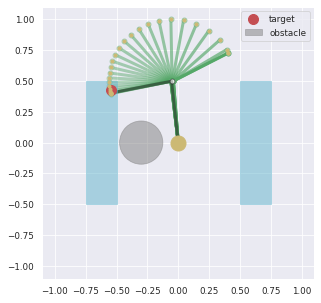

In [14]:
x_obst_np = [x.cpu().numpy() for x in x_obst]
link_lengths_np = link_lengths.cpu().numpy()
rect_patch = [[x_min_pick,y_min_pick, x_max_pick-x_min_pick,  y_max_pick-y_min_pick],
              [x_min_place,y_min_place, x_max_place-x_min_place,  y_max_place-y_min_place]]
plt=plot_chain(joint_loc=joint_loc, link_lengths=link_lengths_np, x_obst=x_obst_np, r_obst=r_obst, rect_patch=rect_patch, x_target=x_target, 
       batch=True, figsize=5, skip_frame=2, title=None, save_as=None, color_intensity=0.9, motion=True, alpha=0.8, 
           contrast=0.4, idx_highlight=[int(joint_loc.shape[0]-1)], lw=3, task=task)
# plt.savefig("reach-2d-tt-opt-7.png",dpi=300, pad_inches=0.01)